In [12]:
import sys
import os

from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.utils import Path, normalize
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from skimage.segmentation import  relabel_sequential
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sys.path.append('../../Terminator/')
import glob
from skimage.filters import sobel
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage.morphology import  binary_dilation, binary_erosion
from skimage.filters import gaussian
from csbdeep.utils import axes_dict, plot_some, plot_history
from tifffile import imread
from csbdeep.utils import Path, normalize
from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D
from TerminatorUtils.helpers import normalizeFloat, OtsuThreshold2D, save_8bit_tiff_imagej_compatible,Integer_to_border,SeedStarDistWatershedLeo
from TerminatorUtils.helpers import Prob_to_Binary, zero_pad_color, multiplot,WingArea,multiplotline
from TerminatorUtils.helpers import save_tiff_imagej_compatible, SeedStarDistWatershed,SeedStarDistWatershedV2,MasktoRoi
from csbdeep.models import Config, CARE
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
np.random.seed(6)
from scipy.ndimage.filters import median_filter, gaussian_filter, maximum_filter
from skimage.filters import threshold_local, threshold_mean, threshold_otsu
lbl_cmap = random_label_cmap()
import napari

In [13]:
Masterdir = '/Users/aimachine/Downloads/Images_For_FAQT'

LeftWingdir = Masterdir + '/Left/'

RightWingdir = Masterdir + '/Right/'

LeftName = 'L'
RightName = 'R'

MaskResultsLeft = LeftWingdir + '/MaskResults/'

MaskResultsRight = RightWingdir + '/MaskResults/'


AsymmetryResults = Masterdir + '/AsymmetryResults/'
AsymmetryResultsName = 'Asymmetry'



In [14]:
Raw_path = os.path.join(LeftWingdir, '*tif')
Left_path = os.path.join(MaskResultsLeft, '*tif')

axes = 'YX'
saveaxes = 'YX'
filesRaw = glob.glob(Raw_path)
filesRaw.sort
filesLeft = glob.glob(Left_path)
filesLeft.sort
RawImages = []
LeftImages = []
Name = []
for fname in filesRaw:
  for secondname in filesLeft:
    if os.path.basename(os.path.splitext(secondname)[0]) == 'Mask' + os.path.basename(os.path.splitext(fname)[0]):
            image = imread(fname)
            Leftimage = imread(secondname) 
            RawImages.append(image)
            LeftImages.append(Leftimage)
            Name.append(os.path.basename(os.path.splitext(fname)[0]))
with napari.gui_qt():
   
    # initialise viewer with Left wing image
    viewer = napari.view_image(np.asarray(RawImages), name='LeftWings', rgb=True)

    # add the labels
    label_layer = viewer.add_labels(np.asarray(LeftImages), name='Leftsegmentation')  
   

In [15]:
ModifiedArray = viewer.layers['Leftsegmentation'].data 

for i in range(0, ModifiedArray.shape[0]):
    
     save_tiff_imagej_compatible((MaskResultsLeft + 'Mask' + Name[i] + '.tif' ) , ModifiedArray[i].astype('uint8'), saveaxes)

In [16]:
Raw_path = os.path.join(RightWingdir, '*tif')
Right_path = os.path.join(MaskResultsRight, '*tif')

axes = 'YX'
saveaxes = 'YX'
filesRaw = glob.glob(Raw_path)
filesRaw.sort
filesRight = glob.glob(Right_path)
filesRight.sort
RawImages = []
RightImages = []
Name = []
for fname in filesRaw:
  for secondname in filesRight:
    if os.path.basename(os.path.splitext(secondname)[0]) == 'Mask' + os.path.basename(os.path.splitext(fname)[0]):
            image = imread(fname)
            Rightimage = imread(secondname) 
            RawImages.append(image)
            RightImages.append(Rightimage)
            Name.append(os.path.basename(os.path.splitext(fname)[0]))
with napari.gui_qt():
   

    # initialise viewer with Left wing image
    viewer = napari.view_image(np.asarray(RawImages), name='RightWings', rgb=True)

    # add the labels
    label_layer = viewer.add_labels(np.asarray(RightImages), name='Rightsegmentation')  

In [17]:
ModifiedArray = viewer.layers['Rightsegmentation'].data 

for i in range(0, ModifiedArray.shape[0]):
    
     save_tiff_imagej_compatible((MaskResultsLeft + 'Mask' + Name[i] + '.tif' ) , ModifiedArray[i].astype('uint8'), saveaxes)

In [18]:
import pandas as pd
Path(AsymmetryResults).mkdir(exist_ok = True)
Raw_pathRight = os.path.join(MaskResultsRight, '*tif')
Raw_pathLeft = os.path.join(MaskResultsLeft, '*tif')

filesRawRight = glob.glob(Raw_pathRight)
filesRawLeft = glob.glob(Raw_pathLeft)


AllRightArea = []
AllLeftArea = []
AllRightMinusLeftArea = []
AllRightPlusLeftArea = []
AllAssymetery = []
AllName = []
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
for fnameRight in filesRawRight:
    
   NameRight = os.path.basename(os.path.splitext(fnameRight)[0]) 
   imageRight = imread(fnameRight)
   for fnameLeft in filesRawLeft:
       NameLeft = os.path.basename(os.path.splitext(fnameLeft)[0]) 
       imageLeft = imread(fnameLeft) 
       ChangeName = NameRight.replace(RightName, LeftName) 
       if ChangeName == NameLeft:
          RightArea, LeftArea, RightMinusLeft, RightPlusLeft, Assymetery = WingArea(imageLeft, imageRight)
          if abs(Assymetery) < 0.1:
           AllName.append(NameLeft)
           AllRightArea.append(RightArea)
           AllLeftArea.append(LeftArea)
           AllRightMinusLeftArea.append(RightMinusLeft)
           AllRightPlusLeftArea.append(RightPlusLeft)
           AllAssymetery.append(Assymetery)
            
df = pd.DataFrame(list(zip(AllRightArea,AllLeftArea,AllRightMinusLeftArea,AllRightPlusLeftArea,AllAssymetery)), index =AllName, 
                                              columns =['RightArea', 'LeftArea', 'Right-Left', 'Right+Left', 'Assymmetery'])

df.to_csv(AsymmetryResults + '/' + AsymmetryResultsName +  '.csv')  
df

,RightArea,LeftArea,Right-Left,Right+Left,Assymmetery
MaskC14L,245302,244481,821,489783,0.003353
MaskB06L,295830,294198,1632,590028,0.005532
MaskB10L,293034,303603,-10569,596637,-0.035429
MaskC02L,249976,246836,3140,496812,0.012641
MaskA03L,276861,276889,-28,553750,-0.000101
MaskA02L,303555,301499,2056,605054,0.006796
MaskD01L,267964,265430,2534,533394,0.009501
MaskA14L,311711,308582,3129,620293,0.010089
MaskC03L,259663,257689,1974,517352,0.007631
MaskB11L,295338,298993,-3655,594331,-0.012300


In [19]:
positivecount = np.sum(df['Assymmetery']>0)
negativecount = np.sum(df['Assymmetery']<0)   
print('Positive Count' , positivecount)
print('Negative Count' , negativecount)

Positive Count 35
Negative Count 21


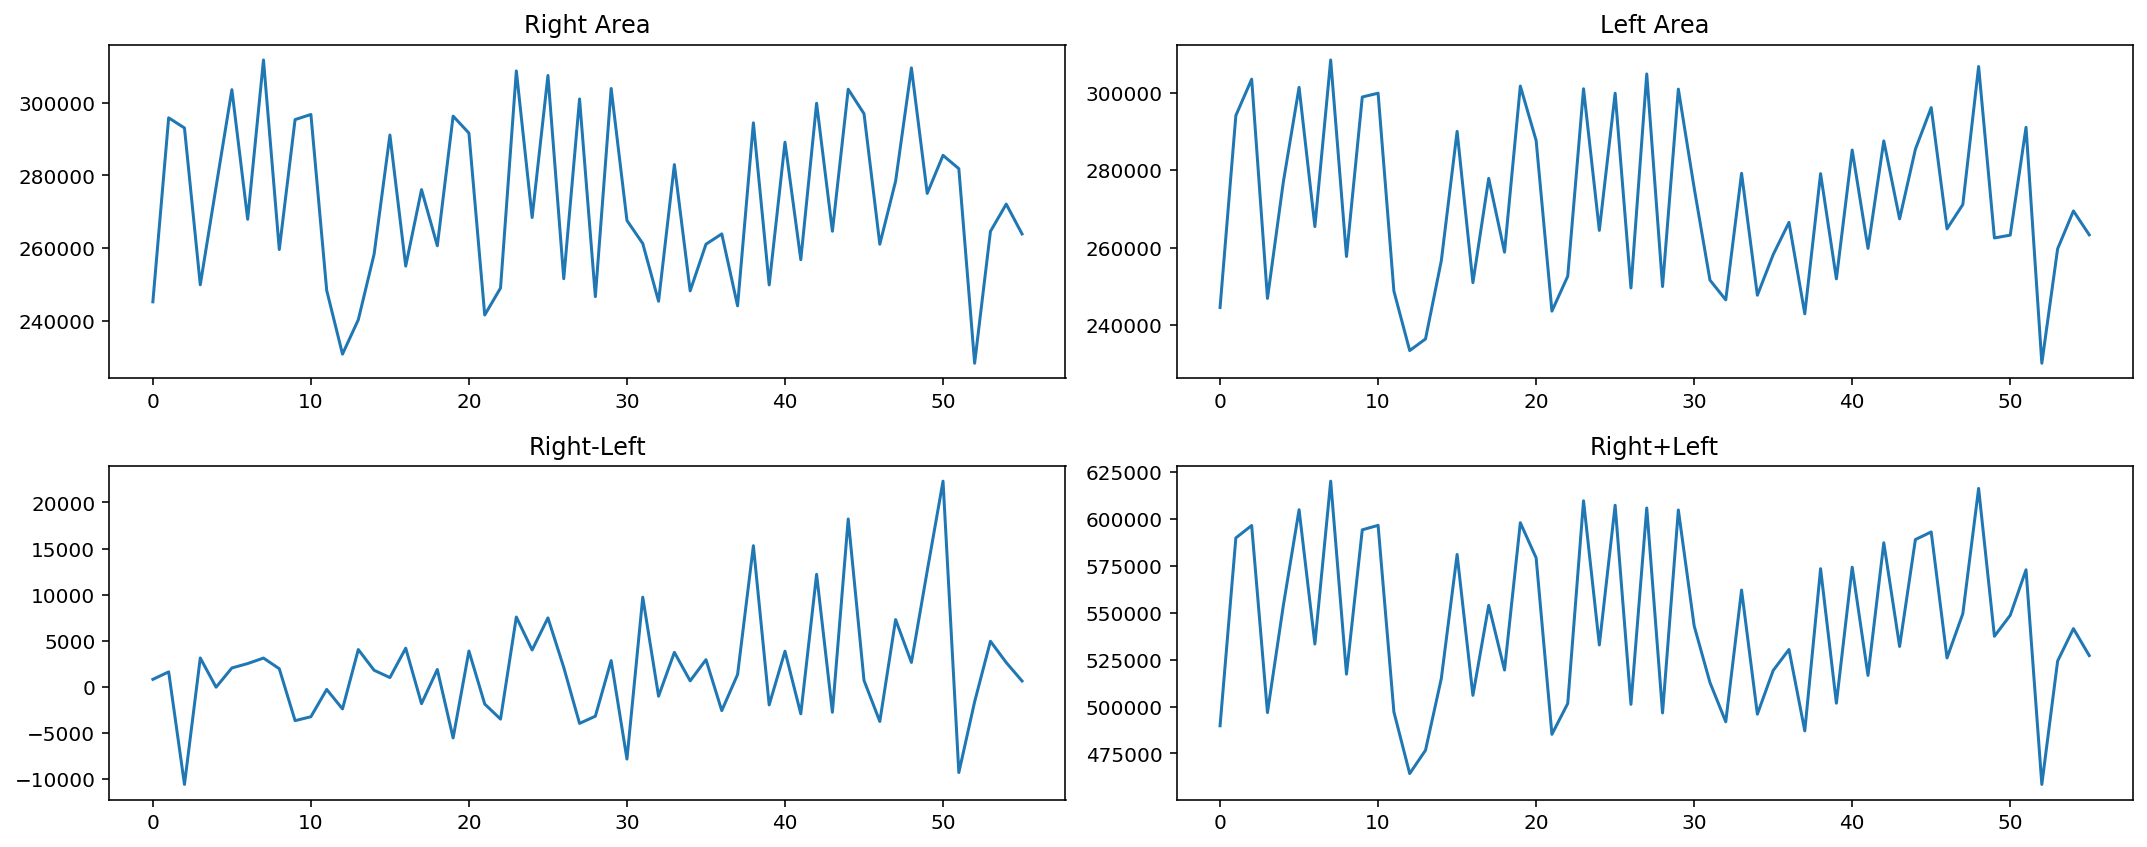

In [20]:
multiplotline(AllRightArea, AllLeftArea, AllRightMinusLeftArea, AllRightPlusLeftArea, 'Right Area', 'Left Area', 'Right-Left', 'Right+Left', targetdir = AsymmetryResults, File = 'Areas', plotTitle = 'Area')


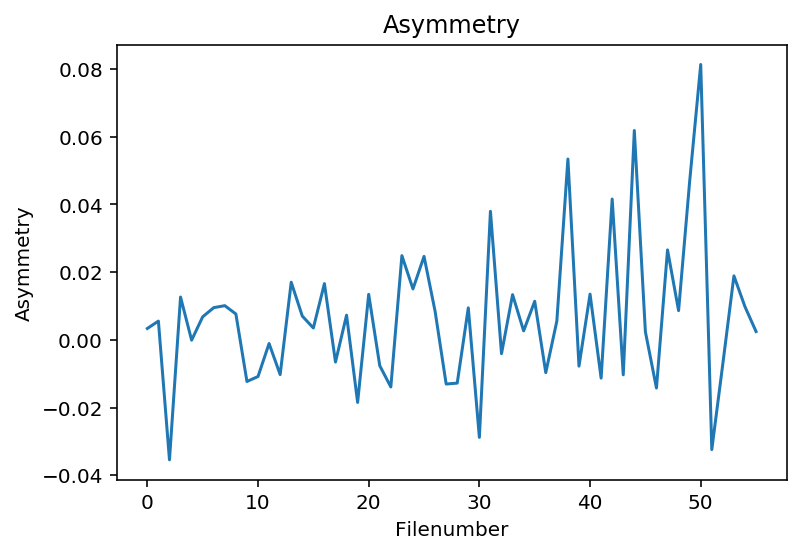

In [21]:
plt.plot(AllAssymetery)
plt.title("Asymmetry")
plt.ylabel("Asymmetry")
plt.xlabel("Filenumber")
plt.show()